In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score   
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, 
    MinMaxScaler,
    RobustScaler,
    )

# for feature engineering
from feature_engine import imputation as mdi
from feature_engine import encoding as ce
from feature_engine import discretisation as disc
from feature_engine import transformation as t
from sklearn.feature_selection import chi2

import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import shap

import xgboost as xgb
from catboost import CatBoostClassifier, Pool, MetricVisualizer, cv

from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args


def summary_table(df):

  print(f'Dataset Shape: {df.shape}')
  
  summary = pd.DataFrame(df.dtypes, columns = ['dtypes'])
  summary = summary.reset_index()
  summary['Name'] = summary['index']
  summary = summary[['Name', 'dtypes']]
  summary['Missing_Ratio'] = df.isnull().sum().values / len(df)
  summary['Uniques_Num'] = df.nunique().values
  summary['Uniques_Ratio'] = summary['Uniques_Num']/ len(df)
  summary['Mean'] = df.mean().values

  return summary

In [3]:
file_name = 'DATASET_THESIS_2022.csv'

df_data = pd.concat([chunk for chunk in tqdm(pd.read_csv(file_name, chunksize=1000), desc='Loading data')])

y = df_data.TARGET

X = df_data.drop(columns=['TARGET'])


Loading data: 154it [00:26,  6.67it/s]


757 columns are derived from the original features

In [17]:
pd.Series([col for col in df_data.columns if '(' in col]).shape

(757,)

In [4]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state= 42)

pipe = Pipeline([
                ('imputer', mdi.MeanMedianImputer(imputation_method='median')),
                # ('scaler', StandardScaler()),
            ])
            
X_train = pipe.fit_transform(X_train)
X_test =  pipe.transform(X_test)

train_pool = Pool(data = X_train, label = y_train, feature_names= [str(x) for x in X.columns])
valid_pool = Pool(data = X_test, label = y_test, feature_names= [str(x) for x in X.columns])


In [5]:
# to study and compare how learning rate influence the underfitting and overfitting

mdl1 = CatBoostClassifier(iterations = 50, max_leaves =80, learning_rate= 0.5,train_dir= 'max_leaves=80', grow_policy = 'Lossguide',custom_loss = 'AUC')
mdl2 = CatBoostClassifier(iterations = 50, max_leaves= 50, learning_rate= 0.5, train_dir= 'max_leaves=50', grow_policy = 'Lossguide', custom_loss = 'AUC')
mdl3 = CatBoostClassifier(iterations = 50, max_leaves= 30,  learning_rate= 0.5, train_dir= 'max_leaves=30', grow_policy = 'Lossguide', custom_loss = 'AUC')
mdl4 = CatBoostClassifier(iterations = 50, max_leaves= 15, learning_rate= 0.5, train_dir= 'max_leaves=15', grow_policy = 'Lossguide', custom_loss = 'AUC')

mdl1.fit(train_pool, eval_set= valid_pool, verbose= 30)
mdl2.fit(train_pool, eval_set= valid_pool, verbose= 30)
mdl3.fit(train_pool, eval_set= valid_pool, verbose= 30)
mdl4.fit(train_pool, eval_set= valid_pool, verbose= 30)

0:	learn: 0.3472232	test: 0.3475339	best: 0.3475339 (0)	total: 2.32s	remaining: 1m 53s
30:	learn: 0.2126004	test: 0.2517995	best: 0.2501404 (10)	total: 31.1s	remaining: 19.1s
49:	learn: 0.1952372	test: 0.2549720	best: 0.2501404 (10)	total: 40.5s	remaining: 0us

bestTest = 0.2501403549
bestIteration = 10

Shrink model to first 11 iterations.
0:	learn: 0.3472858	test: 0.3474963	best: 0.3474963 (0)	total: 1.93s	remaining: 1m 34s
30:	learn: 0.2138405	test: 0.2504612	best: 0.2488702 (15)	total: 25.6s	remaining: 15.7s
49:	learn: 0.1967993	test: 0.2534003	best: 0.2488702 (15)	total: 34.6s	remaining: 0us

bestTest = 0.2488702105
bestIteration = 15

Shrink model to first 16 iterations.
0:	learn: 0.3478416	test: 0.3477178	best: 0.3477178 (0)	total: 1.28s	remaining: 1m 2s
30:	learn: 0.2212509	test: 0.2494892	best: 0.2489291 (17)	total: 22.2s	remaining: 13.6s
49:	learn: 0.2050946	test: 0.2521889	best: 0.2489291 (17)	total: 30.1s	remaining: 0us

bestTest = 0.2489290972
bestIteration = 17

Shrink mo

In [6]:

MetricVisualizer(['max_leaves=80', 'max_leaves=50', 'max_leaves=30', 'max_leaves=15']).start()


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
mdl = CatBoostClassifier(iterations = 30,  custom_loss=['AUC'])

mdl.fit(train_pool, verbose =5, plot = True, eval_set= valid_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.462403
0:	learn: 0.3626189	test: 0.3624889	best: 0.3624889 (0)	total: 166ms	remaining: 4.81s
5:	learn: 0.2495664	test: 0.2515237	best: 0.2515237 (5)	total: 1.11s	remaining: 4.44s
10:	learn: 0.2440625	test: 0.2480329	best: 0.2480329 (10)	total: 2.69s	remaining: 4.65s
15:	learn: 0.2404905	test: 0.2464431	best: 0.2464431 (15)	total: 3.89s	remaining: 3.41s
20:	learn: 0.2378798	test: 0.2463162	best: 0.2461457 (19)	total: 4.92s	remaining: 2.11s
25:	learn: 0.2353700	test: 0.2458036	best: 0.2458036 (25)	total: 5.99s	remaining: 921ms
29:	learn: 0.2332782	test: 0.2451603	best: 0.2451603 (29)	total: 7.28s	remaining: 0us

bestTest = 0.2451603236
bestIteration = 29



In [23]:

params = {
    'loss_function': 'Logloss',
    'iterations': 40,
    'learning_rate': 0.5,
    'custom_loss': 'AUC',
    'verbose': False
}

cv_data = cv(
    params = params, pool = train_pool, fold_count = 5,
    shuffle = True, partition_random_seed= 100, stratified= True, 
    plot = True,  verbose = False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.2449350718
bestIteration = 30

Training on fold [1/5]

bestTest = 0.2446993237
bestIteration = 18

Training on fold [2/5]

bestTest = 0.2451986019
bestIteration = 26

Training on fold [3/5]

bestTest = 0.2475752953
bestIteration = 28

Training on fold [4/5]

bestTest = 0.2495668151
bestIteration = 28



In [ ]:
def get_feature_importance(mdl):

    df_imp_1 = pd.DataFrame(mdl.get_feature_importance(train_pool,prettified= True)) \
                .set_index('Feature Id').rename(columns = {'Importances': 'PredictionValuesChange'}).round(4)

    df_imp_2 = pd.DataFrame(mdl.get_feature_importance(train_pool, 'LossFunctionChange', prettified= True)) \
                .set_index('Feature Id').rename(columns = {'Importances': 'LossFunctionChange'}).round(4)

    return df_imp_1.join(df_imp_2)



In [ ]:
get_feature_importance(mdl).to_excel('feature_importance_catboost.xlsx', index = True)

In [112]:
X_train

array([[-1.49173941e-01, -1.38664032e+00,  1.14436343e+00, ...,
         2.43698782e-02, -3.03171031e-16,  4.96085107e-01],
       [ 1.59136665e+00, -5.25929312e-01, -1.34247604e+00, ...,
        -6.52706392e-02, -3.03171031e-16, -1.57134715e+00],
       [ 8.28261110e-01,  9.06913280e-01, -1.47392883e+00, ...,
        -6.52706392e-02, -3.03171031e-16, -1.23300355e-01],
       ...,
       [-1.63034533e+00, -1.66427209e-01,  1.30948096e+00, ...,
        -6.46277668e-02, -3.03171031e-16,  1.24622184e+00],
       [-1.54564693e+00,  1.65786134e+00, -1.31980387e+00, ...,
         1.75846683e-01, -3.03171031e-16,  1.58360657e+00],
       [-1.47721014e+00, -3.74628026e-01,  8.00158646e-01, ...,
        -8.57733123e-03, -3.03171031e-16,  1.01930393e+00]])

In [114]:
roc_auc_score(y_train, X_test_preds[:,1])


0.789958135954225

In [116]:

# X_test_preds = mdl.predict_proba(X_train)
# roc_auc_score(y_train, X_test_preds[:,1])
accuracy_score(y_train,  mdl.predict(X_train))

0.922589175147345

In [125]:
mdl.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 30,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.1000000015,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.8000000119,
 'use_best_model': True,
 'class_names': [0, 1],
 'random_seed': 0,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'custom_metric': ['AUC'],
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate'

In [124]:
pd.DataFrame(data =dict(mdl.get_all_params()))

ValueError: arrays must all be same length

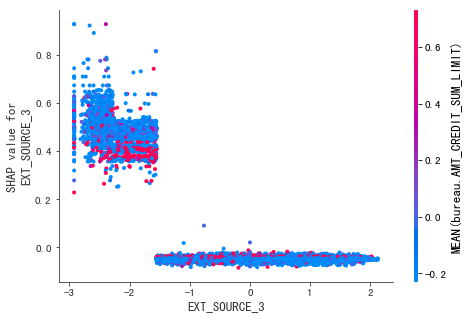

In [46]:
shap.dependence_plot("EXT_SOURCE_3", shap_values, pd.DataFrame(X_test, columns = X.columns))


In [ ]:
mdl.save_model('catboost_model.bin')

In [26]:
mdl = CatBoostClassifier(iterations=10)
mdl.load_model('catboost_model.bin')


In [41]:
explainer = shap.TreeExplainer(mdl)
shap_values = explainer.shap_values(X_test)



AttributeError: 'AxesSubplot' object has no attribute 'inset_axes'

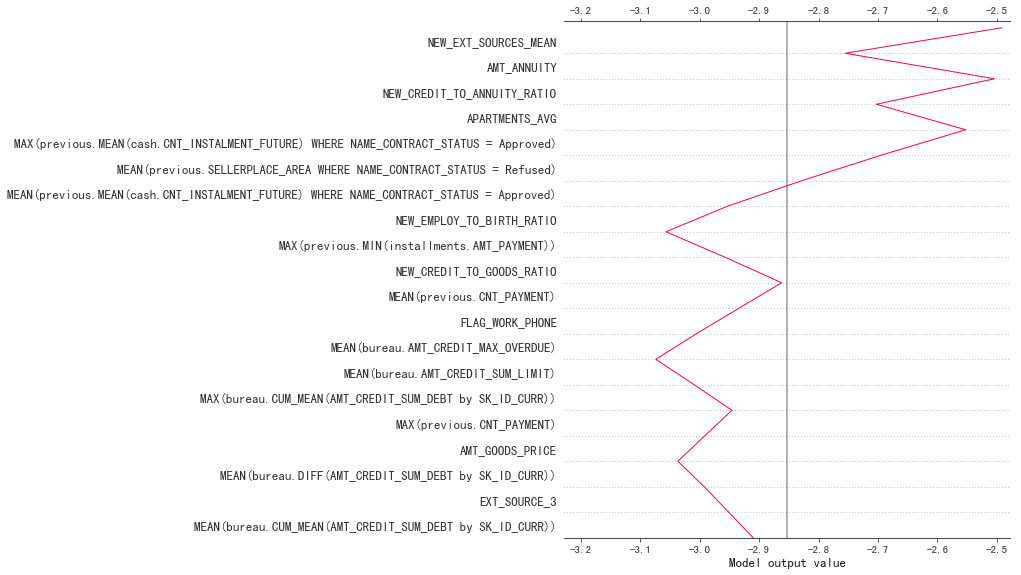

In [96]:
shap.decision_plot(
    base_value = explainer.expected_value, 
    shap_values = shap_values[0,:], 
    features = X.columns,
    )

In [65]:
shap.plots.waterfall(shap_values[1])


AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

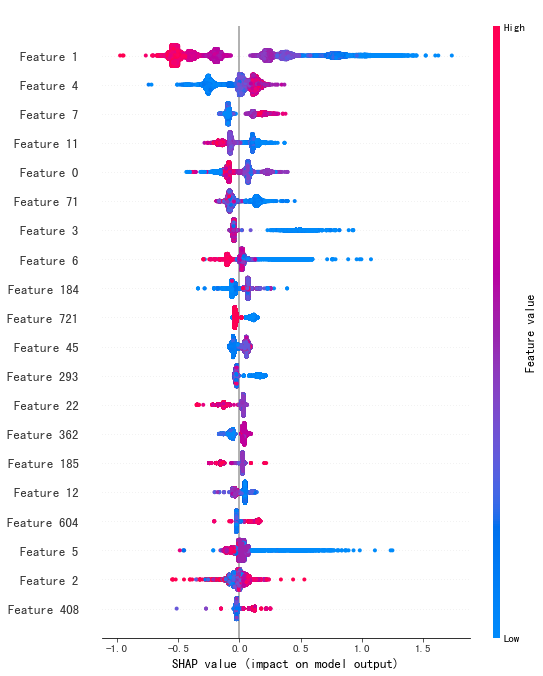

In [68]:
shap.summary_plot(shap_values, pd.DataX_test,  features = X.columns)


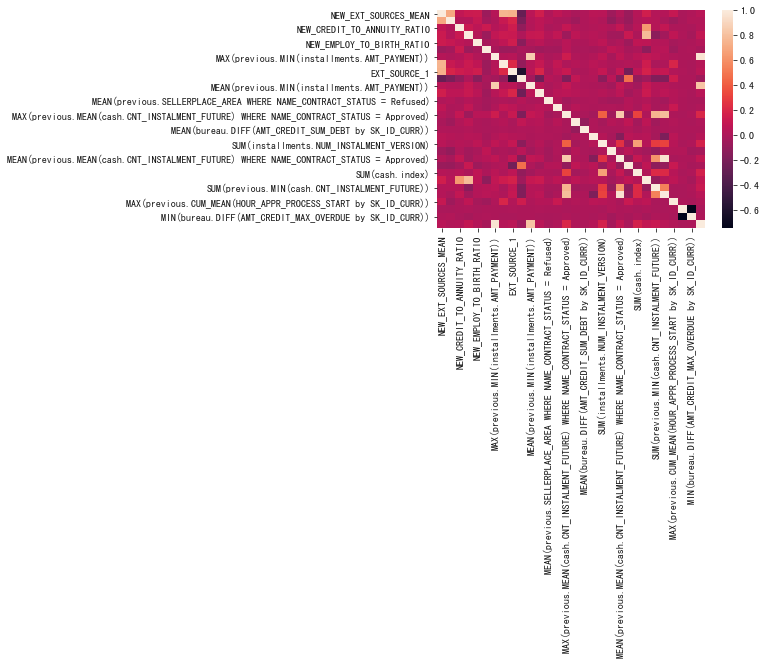

In [106]:
sns.heatmap(
    X[df_feat.head(30)['Feature Id'].values].corr()
)


In [100]:
# shap.initjs()
get_sum
df_feat.head(30)['Feature Id'].values

array(['NEW_EXT_SOURCES_MEAN', 'EXT_SOURCE_3',
       'NEW_CREDIT_TO_ANNUITY_RATIO', 'AMT_ANNUITY',
       'NEW_EMPLOY_TO_BIRTH_RATIO', 'NEW_CREDIT_TO_GOODS_RATIO',
       'MAX(previous.MIN(installments.AMT_PAYMENT))', 'EXT_SOURCE_2',
       'EXT_SOURCE_1', 'DAYS_BIRTH',
       'MEAN(previous.MIN(installments.AMT_PAYMENT))',
       'NEW_CAR_TO_BIRTH_RATIO',
       'MEAN(previous.SELLERPLACE_AREA WHERE NAME_CONTRACT_STATUS = Refused)',
       'APARTMENTS_AVG',
       'MAX(previous.MEAN(cash.CNT_INSTALMENT_FUTURE) WHERE NAME_CONTRACT_STATUS = Approved)',
       'MAX(bureau.CUM_MEAN(AMT_CREDIT_SUM_DEBT by SK_ID_CURR))',
       'MEAN(bureau.DIFF(AMT_CREDIT_SUM_DEBT by SK_ID_CURR))',
       'MAX(previous.CUM_MEAN(RATE_DOWN_PAYMENT by SK_ID_CURR) WHERE NAME_CONTRACT_STATUS = Approved)',
       'SUM(installments.NUM_INSTALMENT_VERSION)',
       'LAST(credit.AMT_INST_MIN_REGULARITY)',
       'MEAN(previous.MEAN(cash.CNT_INSTALMENT_FUTURE) WHERE NAME_CONTRACT_STATUS = Approved)',
       'NEW_IN

In [84]:
df_feat =pd.read_excel('feature_importance_catboost.xlsx').sort_values(by= 'PredictionValuesChange', ascending= False)

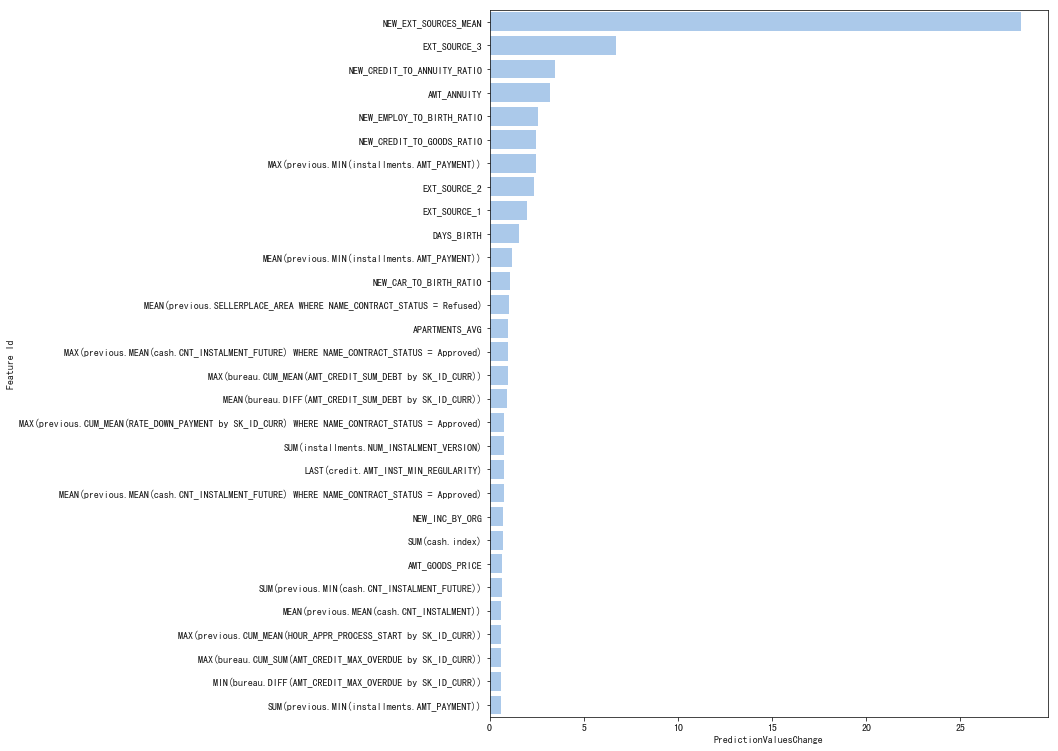

In [95]:
f, ax = plt.subplots(figsize=(10, 13))
sns.set_color_codes("pastel")

sns.barplot(y="Feature Id", x="PredictionValuesChange", data=df_feat.head(30),
            label="Total", color="b")

In [108]:
cols_ = df_feat.head(25)['Feature Id'].values
pd.DataFrame(X_test,columns = X.columns)[cols_].iloc[0, :]

NEW_EXT_SOURCES_MEAN                                                                            -0.222099
EXT_SOURCE_3                                                                                    -0.344453
NEW_CREDIT_TO_ANNUITY_RATIO                                                                     -0.161748
AMT_ANNUITY                                                                                     -0.956097
NEW_EMPLOY_TO_BIRTH_RATIO                                                                       -0.239951
NEW_CREDIT_TO_GOODS_RATIO                                                                       -0.993897
MAX(previous.MIN(installments.AMT_PAYMENT))                                                      0.080968
EXT_SOURCE_2                                                                                     0.567344
EXT_SOURCE_1                                                                                    -1.059207
DAYS_BIRTH                                    

In [82]:
shap.force_plot(explainer.expected_value, shap_values[0,:], pd.DataFrame(X_test,columns = X.columns).iloc[0,:])


ValueError: left cannot be >= right

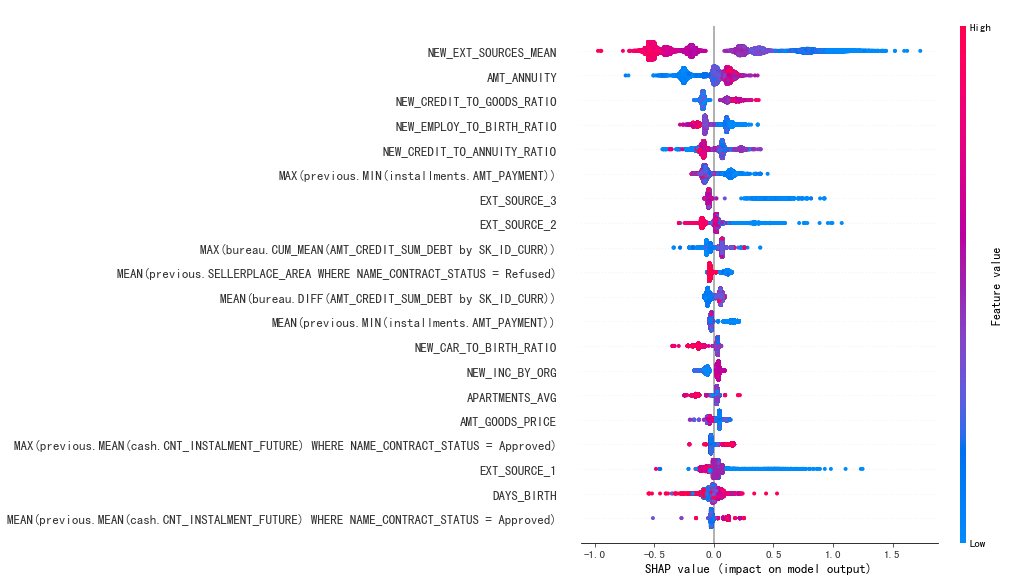

In [73]:
shap.summary_plot(shap_values, pd.DataFrame(X_test,columns = X.columns))


In [128]:
summary_table(pd.DataFrame(df_data,columns = X.columns)[cols_])

Dataset Shape: (153430, 25)


,Name,dtypes,Missing_Ratio,Uniques_Num,Uniques_Ratio,Mean
0,NEW_EXT_SOURCES_MEAN,float64,0.000450,151136,0.985049,5.094562e-01
1,EXT_SOURCE_3,float64,0.197843,790,0.005149,5.113476e-01
2,NEW_CREDIT_TO_ANNUITY_RATIO,float64,0.000039,28407,0.185146,2.162934e+01
3,AMT_ANNUITY,float64,0.000039,11942,0.077834,2.709685e+04
4,NEW_EMPLOY_TO_BIRTH_RATIO,float64,0.180095,125081,0.815232,1.569734e-01
5,NEW_CREDIT_TO_GOODS_RATIO,float64,0.000821,2468,0.016086,1.122992e+00
6,MAX(previous.MIN(installments.AMT_PAYMENT)),float64,0.059917,108106,0.704595,2.750803e+04
7,EXT_SOURCE_2,float64,0.001936,85679,0.558424,5.148010e-01
8,EXT_SOURCE_1,float64,0.563514,61770,0.402594,5.010117e-01
9,DAYS_BIRTH,int64,0.000000,17260,0.112494,-1.603994e+04
